In [1]:
import torch
import pandas as pd
import numpy as np

from tqdm import tqdm
from sae_lens import SAE
from src.judge import get_scores
from matplotlib import pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer

%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Оценка качества генераций

Модель для валидации

__deepseek-r1:8b__, https://ollama.com/library/deepseek-r1:8b

Системный промпт

```
You score texts generated by a language model based on the following criterion:\n
<criterion>.

You provide a score from 1 to 10.
The language model was given a prompt and generated the following text.
Evaluate the text based on the criterion. Output format should be JSON with the following fields: \"score\" (int)
```

Пользовательский промпт

```
Message content

Prompt:

Completion:
"""
<genarated-text>
"""
```



In [2]:
torch.manual_seed(16)
torch.set_grad_enabled(False)

In [3]:

model_name = "google/gemma-2-2b-it"

model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [99]:
conversation = [{"role": "user", "content": "Who are you?"}]
chat = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
inputs = tokenizer.encode(chat, return_tensors="pt", add_special_tokens=True).to("mps")

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_20/width_16k/canonical",
    device = "mps"
)

def generate_with_sae(model,
                      sae: SAE,
                      layer: int,
                      feature_index: int,
                      alpha: float,
                      do_sample: bool,
                      temperature: float,
                      max_len: int,
                      repetition_penalty:float=1.0,
                      normalize_new_hidden=True):

    assert alpha >= 0

    def gather_act_hook(mod, inputs, outputs):

        h = outputs[0]

        try:
            sae_features = sae.encode(h)
            steering = torch.zeros_like(sae_features)
            steering[:, :, feature_index] = alpha
            e_i = sae.decode(steering)
            if normalize_new_hidden:
                h_steer = h + e_i
                h_steer = h_steer / h_steer.norm(dim=-1, keepdim=True) * h.norm(dim=-1, keepdim=True)
            else:
                h_steer = h + e_i
        except:
            print("error")
            h_steer = outputs[0]

        return (h_steer,)

    hook = model.model.layers[layer].register_forward_hook(gather_act_hook)

    outputs = model.generate(inputs,
                             max_length=max_len,
                             temperature=temperature,
                             do_sample=do_sample,
                             repetition_penalty=repetition_penalty,
                             use_cache=False)
    hook.remove()

    return outputs


In [101]:
outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=260.0,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=False)

In [102]:
tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

"I am a large language model, trained by Google.\n\n* I am a large breed of dog, a very big dog, but I don't have a real body.\n* I am a playful and friendly dog,"

In [103]:
from tqdm import tqdm

non_normalized = {}

for alpha in tqdm(np.linspace(0, 500, 20)):
    outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=alpha,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=False)

    non_normalized[alpha] = tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

normalized = {}

for alpha in tqdm(np.linspace(0, 500, 20)):
    outputs = generate_with_sae(model,
                            sae,
                            layer=20,
                            feature_index=12082,
                            alpha=alpha,
                            do_sample=True,
                            temperature=0.5,
                            max_len=60,
                            repetition_penalty=1.0,
                            normalize_new_hidden=True)

    normalized[alpha] = tokenizer.decode(outputs[0], skip_special_tokens=False).split("<start_of_turn>model\n")[1]

100%|██████████| 20/20 [01:16<00:00,  3.80s/it]


In [104]:
import pandas as pd

In [105]:
pd.DataFrame({
    "alpha": non_normalized.keys(),
    "answers": non_normalized.values()
}).to_json("../answers/non_normalized.json")

In [106]:
pd.DataFrame({
    "alpha": normalized.keys(),
    "answers": normalized.values()
}).to_json("../answers/normalized.json")

In [107]:
pd.DataFrame({
    "alpha": normalized.keys(),
    "answers": normalized.values()
})

,alpha,answers
0,0.000000,"I am Gemma, a large language model developed b..."
1,26.315789,"I am Gemma, a large language model created by ..."
2,52.631579,"I am Gemma, a large language model trained by ..."
3,78.947368,"I am Gemma, an AI assistant. I'm a large langu..."
4,105.263158,"I am Gemma, a large language model created by ..."
5,131.578947,"I am Gemma, a large language model trained by ..."
6,157.894737,"I am Gemma, a large language model trained by ..."
7,184.210526,"I am Gemma, a large language model trained by ..."
8,210.526316,"I am Gemma, a large language model trained by ..."
9,236.842105,"I am a large language model, a companion you c..."


In [3]:
non_normalized = pd.read_json("../answers/non_normalized.json")

In [118]:
non_normalized = pd.read_json("../answers/non_normalized.json")

beh_score_for_non_normalized = []
coh_score_for_non_normalized = []
for i, row in tqdm(non_normalized.iterrows()):

    scores = get_scores("dog", row["answers"])
    beh_score_for_non_normalized.append(scores.behavioral_score)
    coh_score_for_non_normalized.append(scores.coherence_score)

non_normalized['behavioral_score'] = beh_score_for_non_normalized
non_normalized['coherence_score'] = coh_score_for_non_normalized

non_normalized['behavioral_score'] /= 10
non_normalized['coherence_score'] /= 10

non_normalized.to_json("../answers/non_normalized.json")

20it [06:42, 20.11s/it]


In [141]:
non_normalized.to_json("../answers/non_normalized.json")

In [ ]:
normalized = pd.read_json("../answers/normalized.json")

beh_score_for_normalized = []
coh_score_for_normalized = []
for i, row in tqdm(normalized.iterrows()):

    scores = get_scores("dog", row["answers"])
    beh_score_for_normalized.append(scores.behavioral_score)
    coh_score_for_normalized.append(scores.coherence_score)

normalized['behavioral_score'] = beh_score_for_normalized
normalized['coherence_score'] = coh_score_for_normalized

normalized['behavioral_score'] /= 10
normalized['coherence_score'] /= 10

In [5]:
normalized

,alpha,answers,behavioral_score,coherence_score
0,0.000000,"I am Gemma, a large language model developed b...",0.2,0.9
1,26.315789,"I am Gemma, a large language model created by ...",0.1,0.8
2,52.631579,"I am Gemma, a large language model trained by ...",0.1,0.6
3,78.947368,"I am Gemma, an AI assistant. I'm a large langu...",0.3,1.0
4,105.263158,"I am Gemma, a large language model created by ...",1.0,0.7
5,131.578947,"I am Gemma, a large language model trained by ...",0.0,0.7
6,157.894737,"I am Gemma, a large language model trained by ...",0.6,0.8
7,184.210526,"I am Gemma, a large language model trained by ...",0.4,0.8
8,210.526316,"I am Gemma, a large language model trained by ...",0.1,0.6
9,236.842105,"I am a large language model, a companion you c...",0.0,0.9


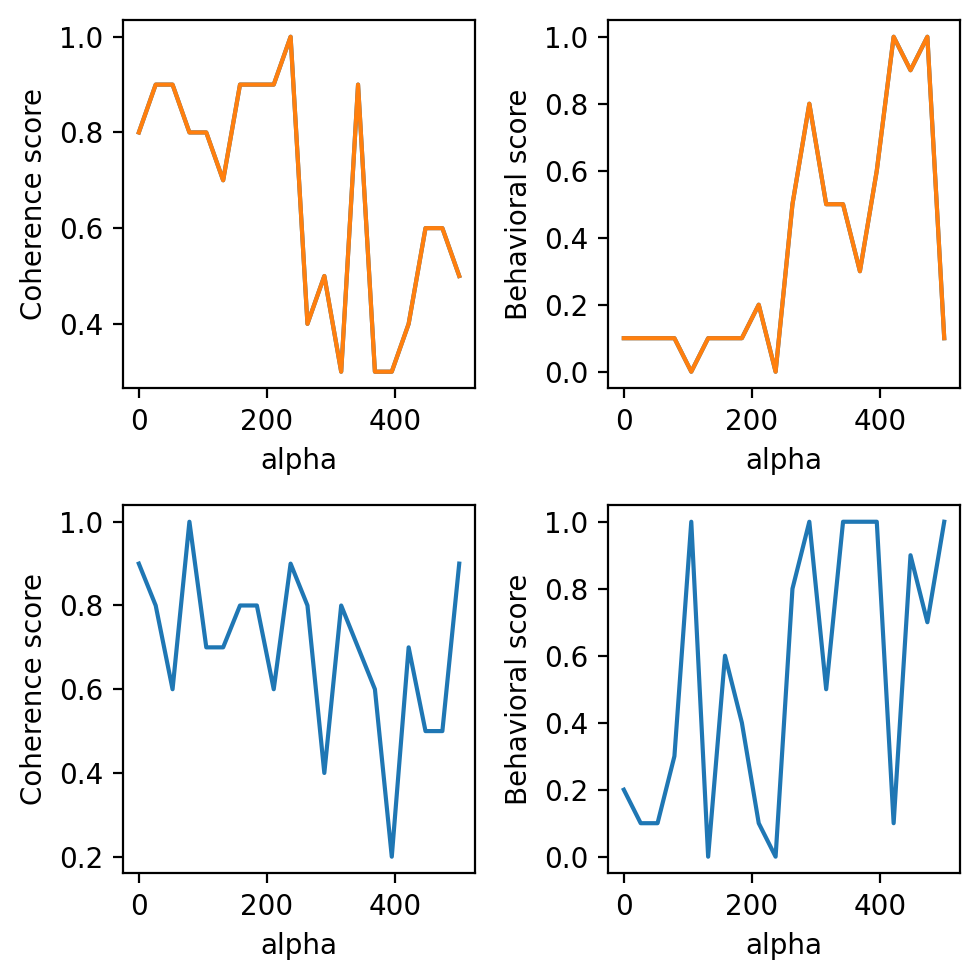

In [10]:
fig, axs = plt.subplots(figsize=(5, 5), ncols=2, nrows=2)

ax = axs.flatten()

ax[0].plot(non_normalized['alpha'], non_normalized['coherence_score'])
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Coherence score")

ax[1].plot(non_normalized['alpha'], non_normalized['behavioral_score'])
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Behavioral score")


ax[0].plot(non_normalized['alpha'], non_normalized['coherence_score'])
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Coherence score")

ax[1].plot(non_normalized['alpha'], non_normalized['behavioral_score'])
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Behavioral score")

ax[2].plot(non_normalized['alpha'], normalized['coherence_score'])
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("Coherence score")

ax[3].plot(non_normalized['alpha'], normalized['behavioral_score'])
ax[3].set_xlabel("alpha")
ax[3].set_ylabel("Behavioral score")

# plt.plot(non_normalized['alpha'], non_normalized['coherence_score'], label="Coherence score")
# plt.plot(non_normalized['alpha'], non_normalized['behavioral_score'], label="Coherence score")
# plt.plot(non_normalized['alpha'], non_normalized['coherence_score'] * non_normalized['behavioral_score'], label="c * b")
#
# plt.
# plt.xlabel("alpha")

fig.tight_layout()
plt.show()